In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

df = pd.read_csv("dataframes/final_df.csv")
df.head()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345906,51.511963,-0.028211,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,0
1,345907,51.371636,-0.117621,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0
2,345908,51.514951,-0.072747,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
3,345909,51.519173,-0.262356,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,345910,51.565743,-0.136308,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


Dropping Vehicle and Casualty related columns. Our analysis is going to focus on the features that can help us predict the cause of the accidents (location, hour, day_of_the_week,...). 
For this reason we discard columns related to the aftermath of the accidents.

In [12]:

df = df.drop(['Car', 'Heavy_Vehicles',
       'Motorcycle', 'Other', 'Pedalcycle', 'casualty_age_0-23',
       'casualty_age_24-30', 'casualty_age_31-38', 'casualty_age_39-50',
       'casualty_age_50+'], axis=1)
print(df.columns)

Index(['id', 'lat', 'lon', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'month', 'day_of_week'],
      dtype='object')


In [13]:
X = df.drop(columns=['severity', 'id'])
y = df['severity']  # Assicurati che sia numerico o mappato (1, 2, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 41)
(10126, 41)
(40500,)
(10126,)


## XGBClassifier using sample weights

In [14]:
random_state=42

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

base_xgb_model = XGBClassifier(random_state=random_state)
base_xgb_model.fit(X_train, y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.914     0.746     0.821      8547
           1      0.309     0.606     0.409      1527
           2      0.288     0.808     0.424        52

    accuracy                          0.725     10126
   macro avg      0.503     0.720     0.552     10126
weighted avg      0.819     0.725     0.757     10126



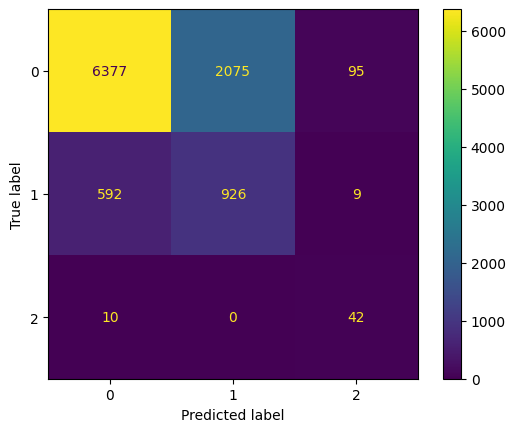

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = base_xgb_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

Printing Feature Importance from XGBoost and Permutation Importance.

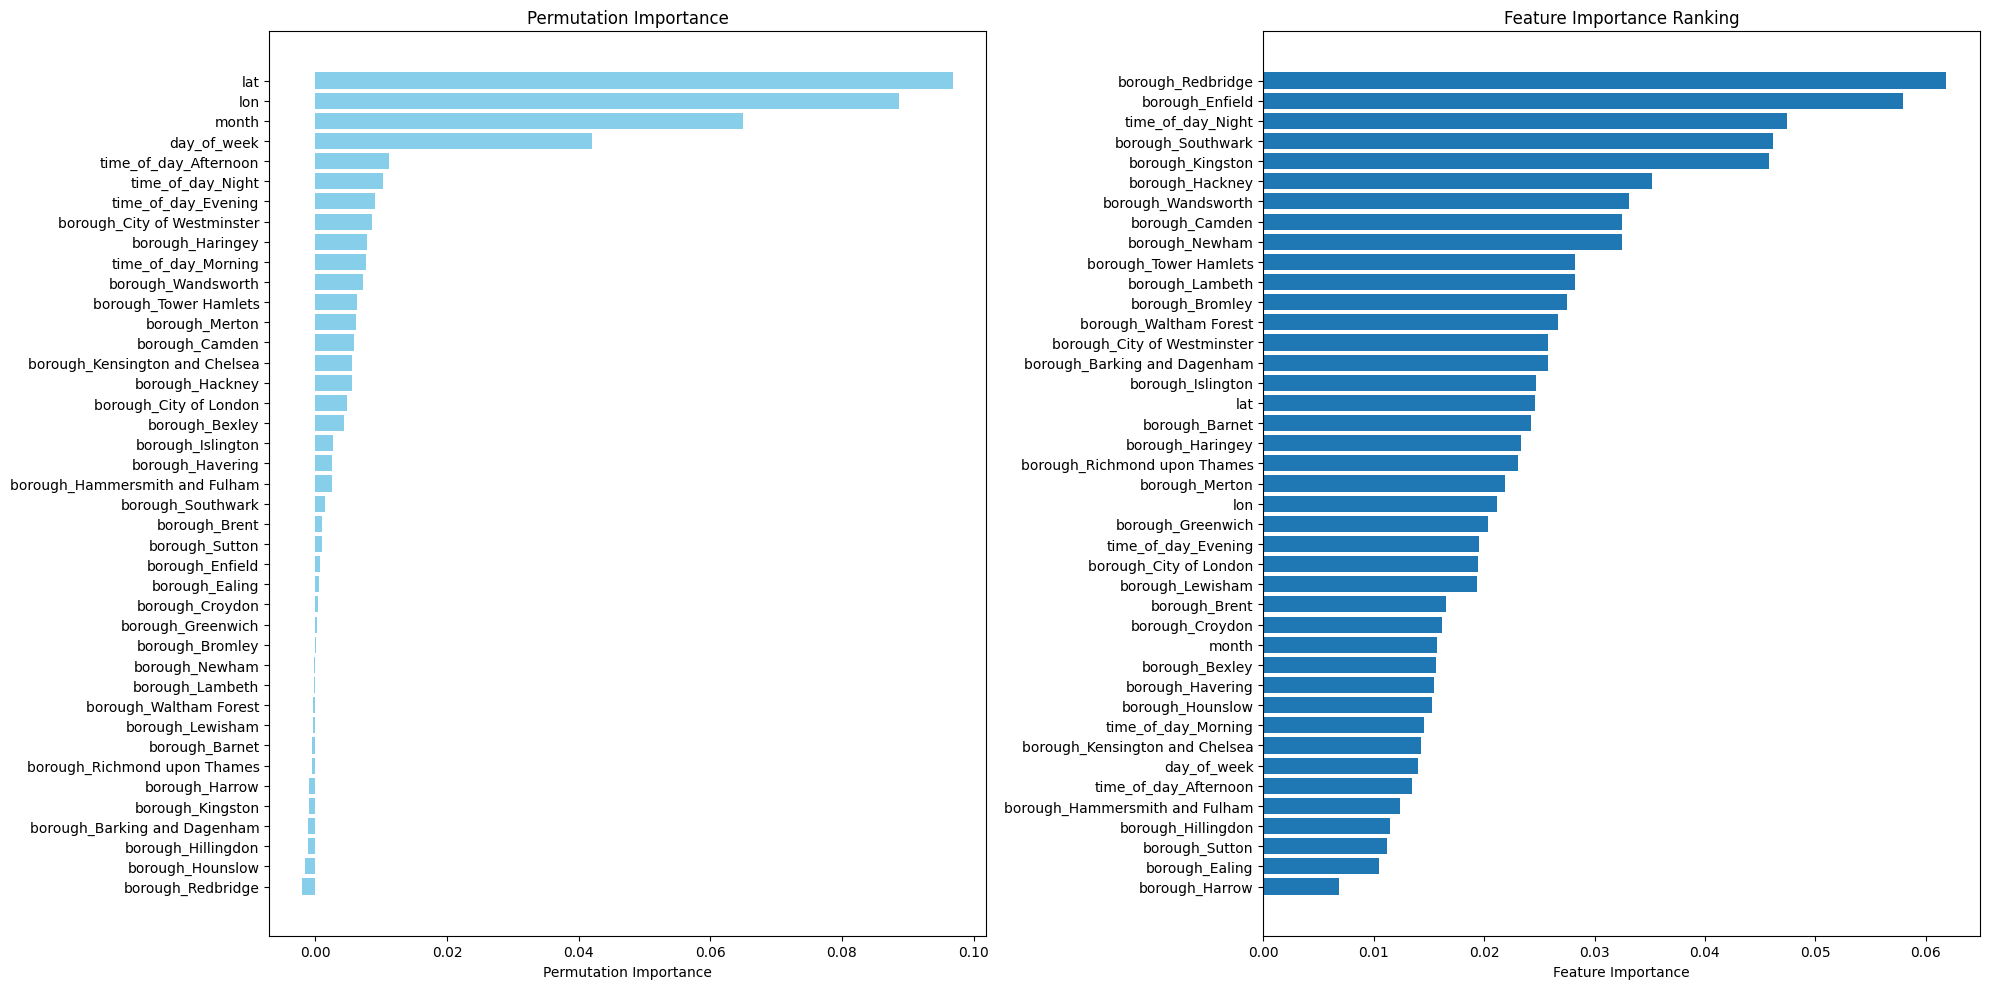

In [16]:
from sklearn.inspection import permutation_importance
feature_importance = base_xgb_model.feature_importances_

r_train = permutation_importance(base_xgb_model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()

# plt.figure(figsize=(16, 16))
# plt.barh(X_train.columns[sorted_idx], r_train.importances_mean[sorted_idx], color="skyblue")
# plt.xlabel("Permutation Importance")
# plt.title("Feature Importance via Permutation")
# plt.show()

# plt.figure(figsize=(20,20))
# sorted_idx = np.argsort(feature_importance)
# plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
# plt.xlabel("Feature Importance")
# plt.show()

In [20]:
from sklearn.metrics import roc_auc_score
y_probs = base_xgb_model.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_probs, multi_class='ovr')
print(xbm_score_test)

0.7857291944812758


## XGBClassifier using sample weights and ADASYN for resampling

We also applied some GridSearch to find the best hyperparameters for XGBoost.

In [7]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import pandas as pd

X = df.drop(columns=['severity', 'id'])
y = df['severity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_res)

param_grid = {
    'learning_rate': [0.1 ,0.2, 0.3],
    'max_depth': [9, 11, 13],
    'subsample': [1.0, 1.2, 1.4],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'n_estimators': [100, 200, 300],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0.0, 0.1, 1.0],
    # 'reg_lambda': [1.0, 1.5, 2.0],
}

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,                
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_res, y_res, sample_weight=sample_weights)

print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

model_xgb_adysin = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ......learning_rate=0.1, max_depth=9, subsample=1.2; total time=   0.1s
[CV] END ......learning_rate=0.1, max_depth=9, subsample=1.2; total time=   0.1s
[CV] END ......learning_rate=0.1, max_depth=9, subsample=1.2; total time=   0.1s
[CV] END ......learning_rate=0.1, max_depth=9, subsample=1.4; total time=   0.1s
[CV] END ......learning_rate=0.1, max_depth=9, subsample=1.4; total time=   0.1s
[CV] END ......learning_rate=0.1, max_depth=9, subsample=1.4; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=11, subsample=1.2; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=11, subsample=1.2; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=11, subsample=1.2; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=11, subsample=1.4; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=11, subsample=1.4; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=11, s

/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....learning_rate=0.2, max_depth=11, subsample=1.4; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=13, subsample=1.0; total time=   4.2s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=1.4; total time=   0.1s
[CV] END .....learning_rate=0.1, max_depth=13, subsample=1.0; total time=   4.2s
[CV] END .....learning_rate=0.2, max_depth=13, subsample=1.2; total time=   0.1s
[CV] END .....learning_rate=0.2, max_depth=13, subsample=1.2; total time=   0.1s
[CV] END .....learning_rate=0.2, max_depth=13, subsample=1.2; total time=   0.1s
[CV] END .....learning_rate=0.2, max_depth=13, subsample=1.4; total time=   0.1s
[CV] END .....learning_rate=0.2, max_depth=13, subsample=1.4; total time=   0.1s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=1.0; total time=   3.0s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=1.0; total time=   3.1s
[CV] END .....learning_rate=0.2, max_depth=11, subsample=1.0; total time=   3.1s
[CV] END .....learning_rate=

/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
54 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/pyt


Best Parameters: {'learning_rate': 0.3, 'max_depth': 13, 'subsample': 1.0}
Best F1 Score: 0.8965015485658663



Classification Report:
              precision    recall  f1-score   support

      Slight      0.962     0.939     0.951      8613
     Serious      0.692     0.792     0.739      1465
       Fatal      0.872     0.708     0.782        48

    accuracy                          0.917     10126
   macro avg      0.842     0.813     0.824     10126
weighted avg      0.923     0.917     0.919     10126



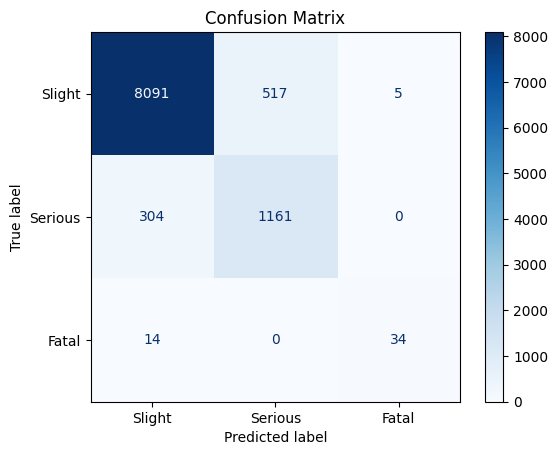

In [8]:
y_pred = model_xgb_adysin.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious', 'Fatal'], digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious', 'Fatal'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Computing ROC_AUC score for the model with the best parameter found.

In [9]:
from sklearn.metrics import roc_auc_score

xbm_score_cv = grid_search.best_score_  
y_proba      = model_xgb_adysin.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')
xbm_params     = grid_search.best_params_

print(f'AUC score for {xbm_params}: {xbm_score_cv:.2f} (cross-val.), {xbm_score_test:.2f} (test)')

AUC score for {'learning_rate': 0.3, 'max_depth': 13, 'subsample': 1.0}: 0.90 (cross-val.), 0.90 (test)


Printing Feature Importance and Permutation Importance from the obtained model.

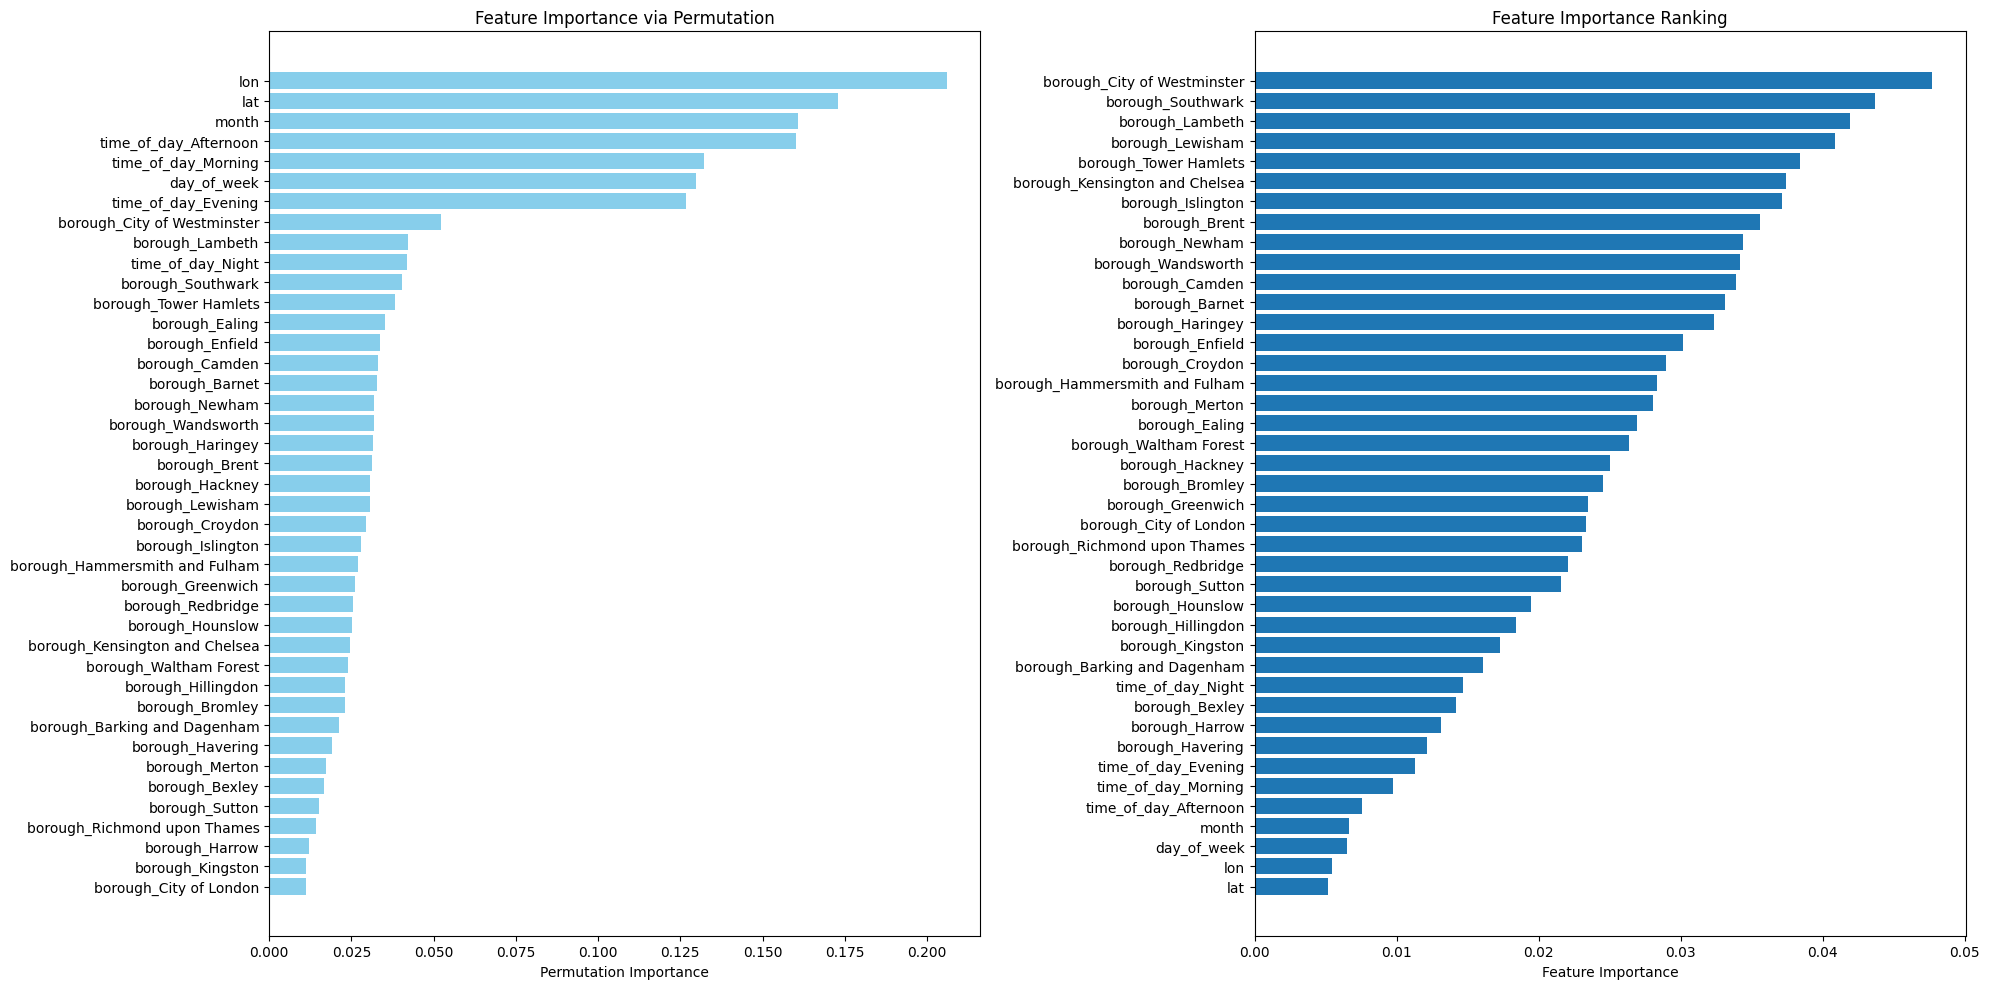

In [10]:
from sklearn.inspection import permutation_importance

feature_importance = model_xgb_adysin.feature_importances_

r_train = permutation_importance(model_xgb_adysin, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Feature Importance via Permutation")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()
# plt.figure(figsize=(20,20))
# sorted_idx = np.argsort(feature_importance)
# plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
# plt.xlabel("Feature Importance")
# plt.show()

In [46]:
print(df['severity'].value_counts())

severity
0    43060
1     7326
2      240
Name: count, dtype: int64


## Analysis Function

Here is a function to easily analyze different approaches. An XGBClassifier is used, a Grid Search is used to find the best hyperparameters. We can decide how to resample data: only train set, only test set, both of them or not using resampling at all. Also using sample weights to balance out the frequencies of the classes, since our dataset is very unbalanced.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import ADASYN

from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

def analyze_balancing_approaches(
    df,
    approach="none",        
    shuffle_data=True,    
    param_grid=None,       
    random_state=42
):
   
    if 'severity' not in df.columns:
        raise ValueError("The DataFrame must contain a 'severity' column as the target.")

    if param_grid is None:
        param_grid = {
            'learning_rate': [0.2, 0.3],
            'max_depth': [9, 11],
            'subsample': [0.8, 1.0],  
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            # 'n_estimators': [100, 200, 300],
            # 'gamma': [0, 0.1, 0.2],
            # 'reg_alpha': [0.0, 0.1, 1.0],
            # 'reg_lambda': [1.0, 1.5, 2.0],
        }


    X = df.drop(columns=['severity', 'id'])
    y = df['severity']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,         
        shuffle=shuffle_data,
        random_state=random_state
    )


    if approach == "none":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
        X_test_res, y_test_res   = X_test.copy(), y_test.copy()

    elif approach == "entire":
        adasyn_entire = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_entire.fit_resample(X_train, y_train)

        adasyn_entire_test = ADASYN(random_state=random_state + 1)
        X_test_res, y_test_res = adasyn_entire_test.fit_resample(X_test, y_test)

    elif approach == "train_only":
        adasyn_train = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_train.fit_resample(X_train, y_train)

        X_test_res, y_test_res = X_test.copy(), y_test.copy()

    elif approach == "test_only":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()

        adasyn_test = ADASYN(random_state=random_state)
        X_test_res, y_test_res = adasyn_test.fit_resample(X_test, y_test)

    else:
        raise ValueError(
            "approach must be one of ['none', 'entire', 'train_only', 'test_only']"
        )


    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_res)

    xgb_model = XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(y)), 
        eval_metric='mlogloss',
        random_state=random_state,
        n_jobs=-1
    )

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='f1_macro', 
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)
    model = grid_search.best_estimator_

    print("\n===== Grid Search Results =====")
    print("Best Parameters:", grid_search.best_params_)
    print("Best F1 (CV):", grid_search.best_score_)

    y_pred = model.predict(X_test_res)

    print("\n===== Classification Report (Test) =====")
    print(classification_report(
        y_test_res, y_pred,
        target_names=['Slight', 'Serious', 'Fatal'],
        digits=3
    ))

    cm = confusion_matrix(y_test_res, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Slight', 'Serious', 'Fatal']
    )
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    y_proba = model.predict_proba(X_test_res)
    auc_test = roc_auc_score(y_test_res, y_proba, multi_class='ovr')
    print(f"\nAUC (Test) = {auc_test:.3f}")


    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(10, 8))
    plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], color="skyblue")
    plt.xlabel("Feature Importance (XGBoost built-in)")
    plt.title("Feature Importance by Gain")
    plt.tight_layout()
    plt.show()
    r_train = permutation_importance(
        model,
        X_train_res,
        y_train_res,
        n_repeats=30,
        random_state=random_state
    )

    perm_sorted_idx = r_train.importances_mean.argsort()

    plt.figure(figsize=(10, 8))
    plt.barh(X_train.columns[perm_sorted_idx],
             r_train.importances_mean[perm_sorted_idx],
             color="skyblue")
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance via Permutation")
    plt.tight_layout()
    plt.show()

    return model, grid_search


Let's apply XGBoost with no resampling at all.

Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.7220391966512175

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.966     0.958     0.962      8613
     Serious      0.765     0.810     0.787      1465
       Fatal      0.900     0.750     0.818        48

    accuracy                          0.935     10126
   macro avg      0.877     0.839     0.856     10126
weighted avg      0.937     0.935     0.936     10126



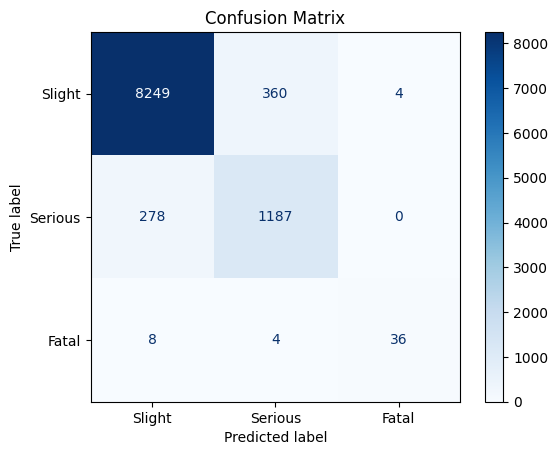


AUC (Test) = 0.906


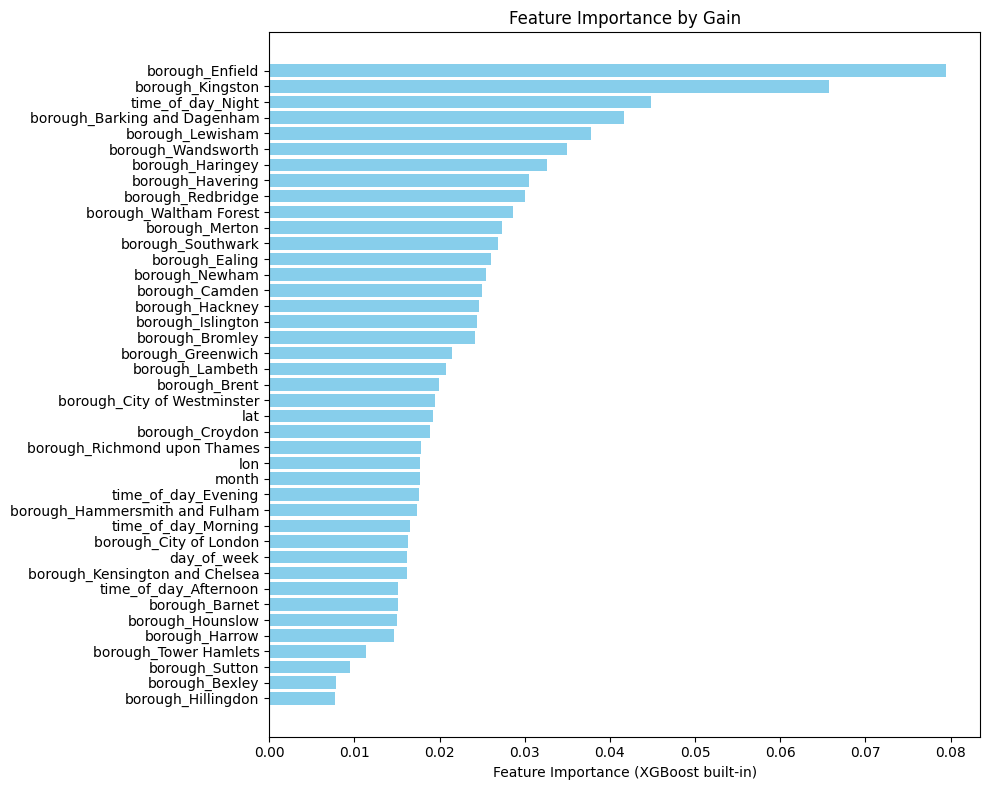

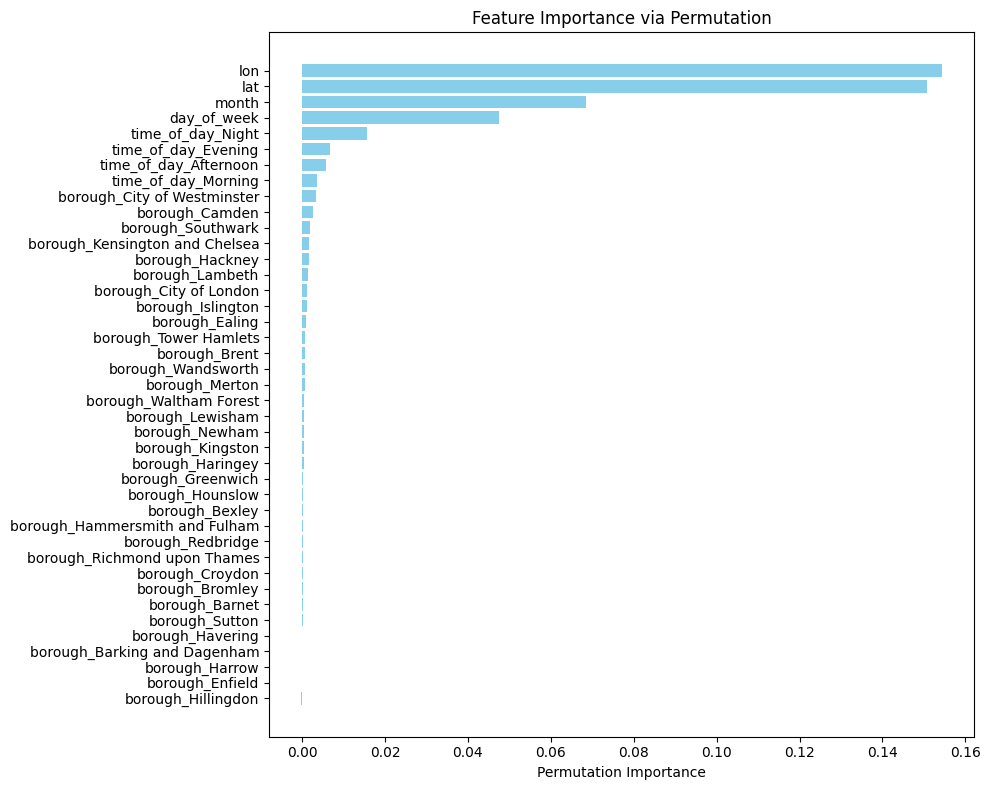

In [48]:
model_none, gs_none = analyze_balancing_approaches(df, approach="none")

Now resampling both train and test set.

Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.88276946932526

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.834     0.923     0.876      8613
     Serious      0.819     0.716     0.764      8946
       Fatal      0.845     0.867     0.856      8616

    accuracy                          0.834     26175
   macro avg      0.833     0.835     0.832     26175
weighted avg      0.833     0.834     0.831     26175



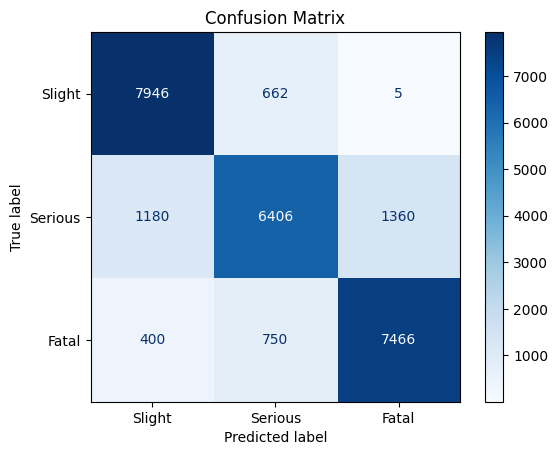


AUC (Test) = 0.940


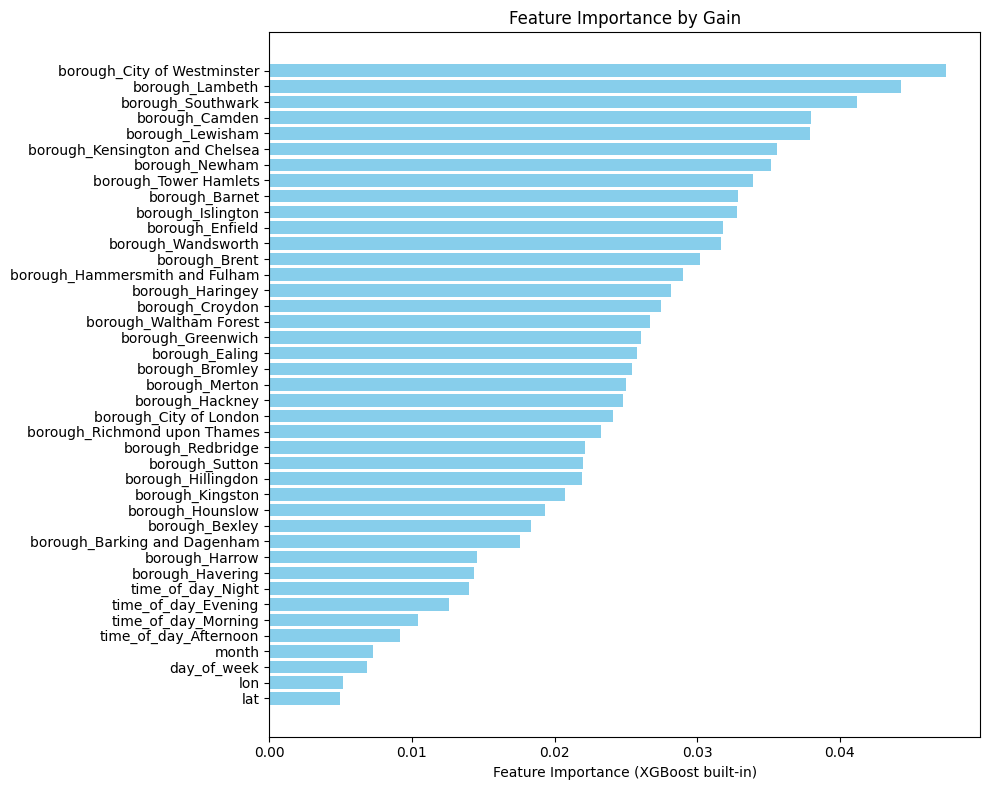

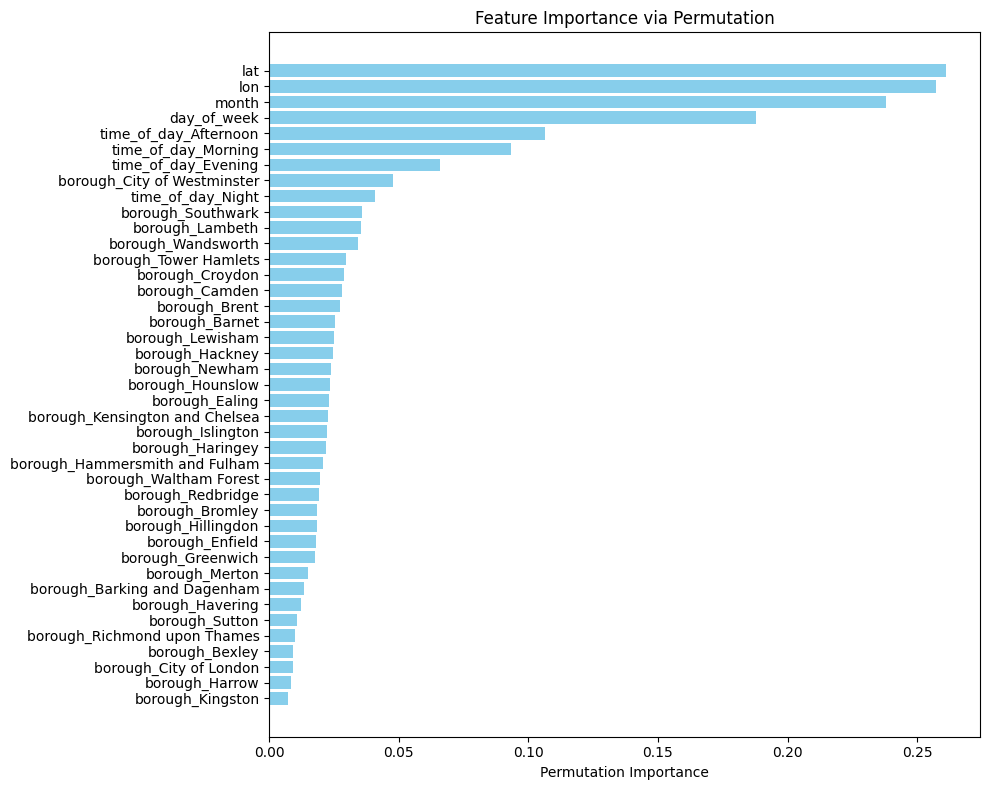

In [49]:
model_entire, gs_entire = analyze_balancing_approaches(df, approach="entire")

Only resampling training set.

Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.88276946932526

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.951     0.923     0.937      8613
     Serious      0.617     0.734     0.671      1465
       Fatal      0.800     0.500     0.615        48

    accuracy                          0.893     10126
   macro avg      0.790     0.719     0.741     10126
weighted avg      0.902     0.893     0.897     10126



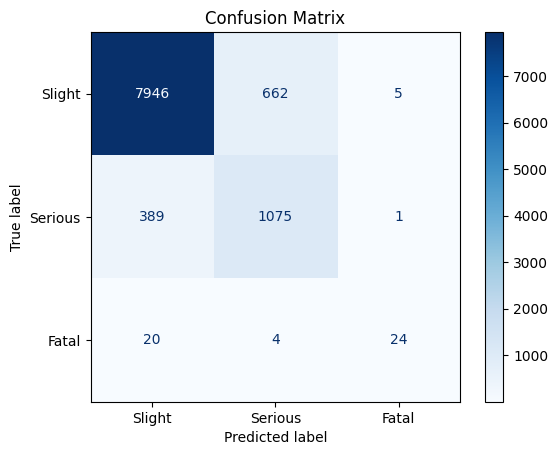


AUC (Test) = 0.891


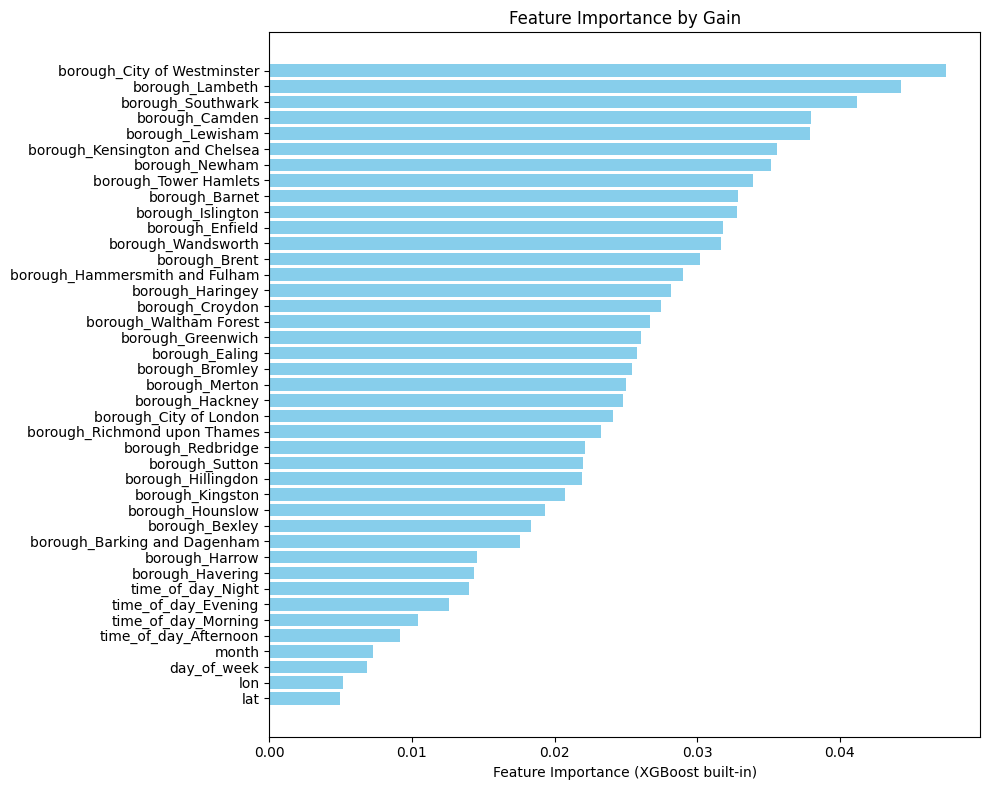

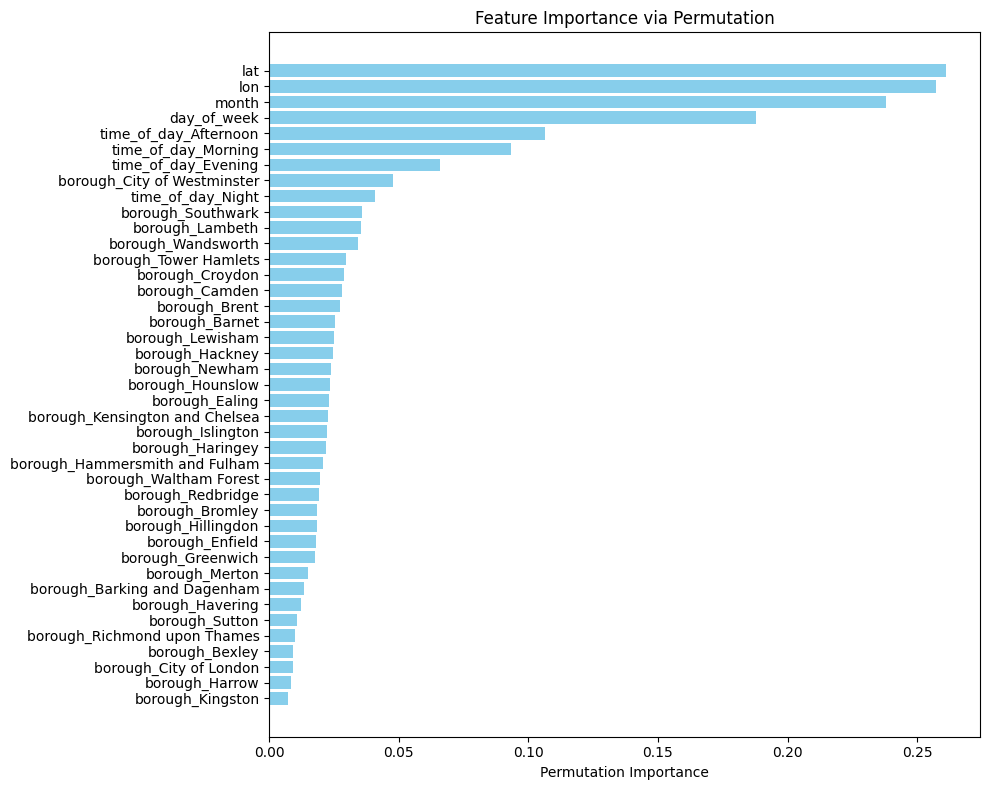

In [50]:
model_train, gs_train = analyze_balancing_approaches(df, approach="train_only")

Here is a function to analyze the different features. Since 'boroughs' and 'lat'/'lon' both express the location of the accident, they can be redundant. For this reason we're gonna keep only one of the two, and see which one allows us to have a more accurate model.  

We're gonna resample only the train set, since we've previously seen that this strategy improves the performances of our classification model.

In [51]:
def analyze_features(
    df_merged,
    mode="borough",      
    approach="train_only",
    shuffle_data=True,
    param_grid=None,
    random_state=42
):
   

    if 'severity' not in df_merged.columns:
        raise ValueError("The DataFrame must contain 'severity' as the target.")

    df_copy = df_merged.copy()

    print("Removing cols based on selection: ", mode)
    borough_cols = [col for col in df_copy.columns if col.startswith('borough_')]
    if mode == "borough":
        drop_cols = ['lat', 'lon']
        for c in drop_cols:
            if c in df_copy.columns:
                df_copy.drop(columns=[c], inplace=True)
    elif mode == "lat_lon":
        df_copy.drop(columns=borough_cols, inplace=True, errors='ignore')
    elif mode == "all":
        pass
    else:
        raise ValueError("mode must be one of ['borough', 'lat_lon', 'all']")

    if param_grid is None:
        param_grid = {
            'learning_rate': [0.2, 0.3],
            'max_depth': [9, 11],
            'subsample': [0.8, 1.0],  
     
        }

    X = df_copy.drop(columns=['severity', 'id'])
    y = df_copy['severity']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        shuffle=shuffle_data,
        random_state=random_state
    )

    print("Setting train test splits based on approach: ", approach)
    if approach == "none":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
        X_test_res, y_test_res   = X_test.copy(), y_test.copy()

    elif approach == "entire":
        adasyn_entire = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_entire.fit_resample(X_train, y_train)

        adasyn_entire_test = ADASYN(random_state=random_state + 1)
        X_test_res, y_test_res = adasyn_entire_test.fit_resample(X_test, y_test)

    elif approach == "train_only":
        adasyn_train = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_train.fit_resample(X_train, y_train)

        X_test_res, y_test_res = X_test.copy(), y_test.copy()

    elif approach == "test_only":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()

        adasyn_test = ADASYN(random_state=random_state)
        X_test_res, y_test_res = adasyn_test.fit_resample(X_test, y_test)

    else:
        raise ValueError("approach must be one of ['none','entire','train_only','test_only']")

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_res)

    xgb_model = XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(y)), 
        eval_metric='mlogloss',
        random_state=random_state,
        n_jobs=-1
    )
    print("Initiating Grid Search")
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)
    model = grid_search.best_estimator_

    print("\n===== Grid Search Results =====")
    print("Best Parameters:", grid_search.best_params_)
    print("Best F1 (CV):", grid_search.best_score_)

    y_pred = model.predict(X_test_res)

    print("\n===== Classification Report (Test) =====")
    print(classification_report(
        y_test_res, y_pred,
        target_names=['Slight', 'Serious', 'Fatal'],
        digits=3
    ))

    cm = confusion_matrix(y_test_res, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Slight','Serious','Fatal'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix: {mode} | {approach}")
    plt.show()

    y_proba = model.predict_proba(X_test_res)
    auc_test = roc_auc_score(y_test_res, y_proba, multi_class='ovr')
    print(f"\nAUC (Test) = {auc_test:.3f}")

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(8, 6))
    plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], color="skyblue")
    plt.xlabel("Feature Importance (XGBoost built-in)")
    plt.title(f"Feature Importance by Gain ({mode} | {approach})")
    plt.tight_layout()
    plt.show()

    r_train = permutation_importance(
        model,
        X_train_res,
        y_train_res,
        n_repeats=30,
        random_state=random_state
    )
    perm_sorted_idx = r_train.importances_mean.argsort()

    plt.figure(figsize=(8, 6))
    plt.barh(X_train.columns[perm_sorted_idx],
             r_train.importances_mean[perm_sorted_idx],
             color="skyblue")
    plt.xlabel("Permutation Importance")
    plt.title(f"Permutation Importance ({mode} | {approach})")
    plt.tight_layout()
    plt.show()

    return model, grid_search


Borough columns only, resample train only (common approach)

Removing cols based on selection:  borough
Setting train test splits based on approach:  train_only
Initiating Grid Search
Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.8015765594865081

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.896     0.771     0.828      8613
     Serious      0.272     0.486     0.349      1465
       Fatal      0.039     0.083     0.053        48

    accuracy                          0.726     10126
   macro avg      0.402     0.447     0.410     10126
weighted avg      0.801     0.726     0.755     10126



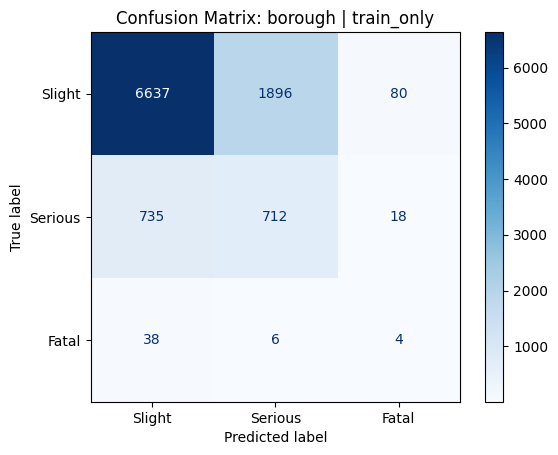


AUC (Test) = 0.771


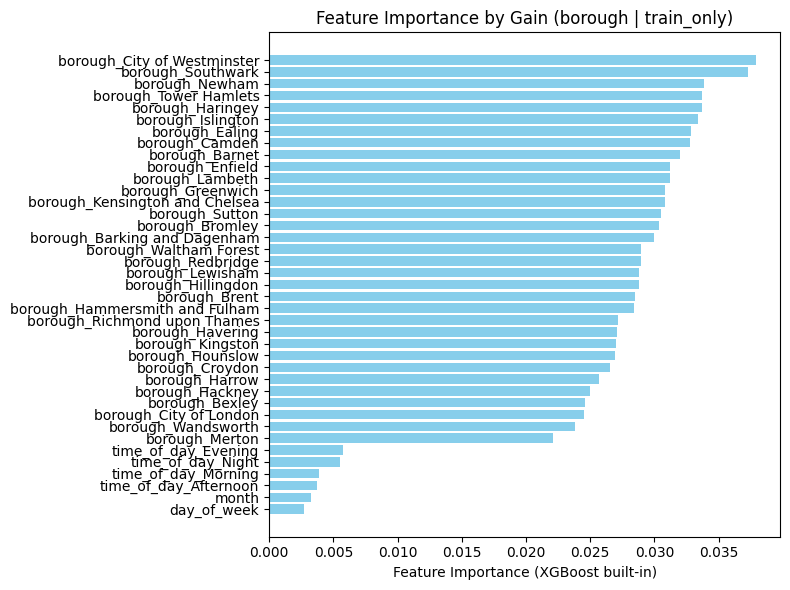

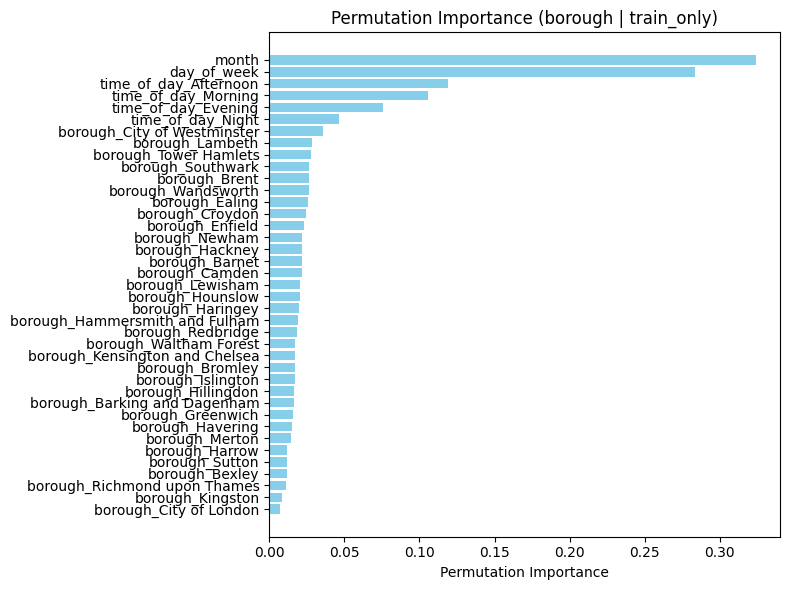

In [52]:
model_borough_train, gs_borough_train = analyze_features(
    df, 
    mode="borough", 
    approach="train_only"
)

Now keeping 'Lat' and 'Lon' and dropping 'Boroughs'. Still resampling only the train set.

Removing cols based on selection:  lat_lon
Setting train test splits based on approach:  train_only
Initiating Grid Search
Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.8198586430958169

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.960     0.847     0.900      8613
     Serious      0.487     0.785     0.601      1465
       Fatal      0.229     0.750     0.351        48

    accuracy                          0.838     10126
   macro avg      0.558     0.794     0.617     10126
weighted avg      0.888     0.838     0.854     10126



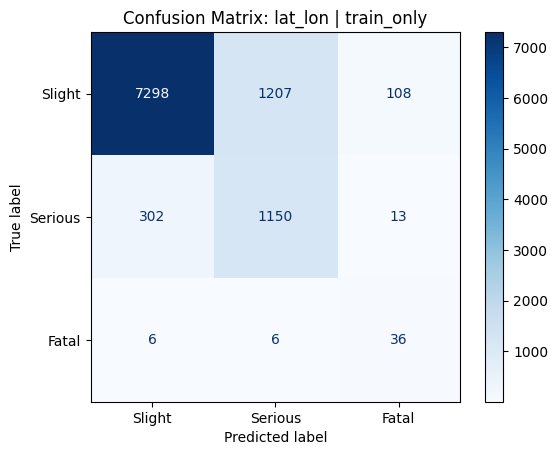


AUC (Test) = 0.873


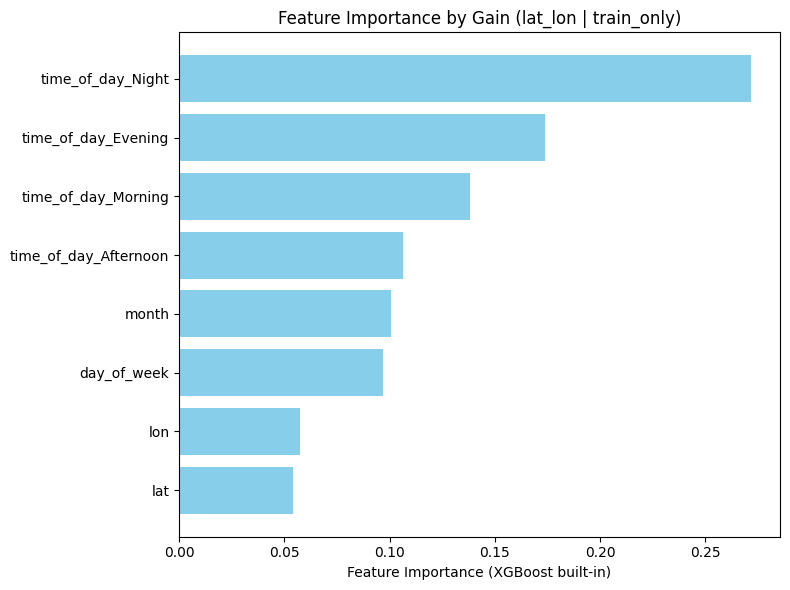

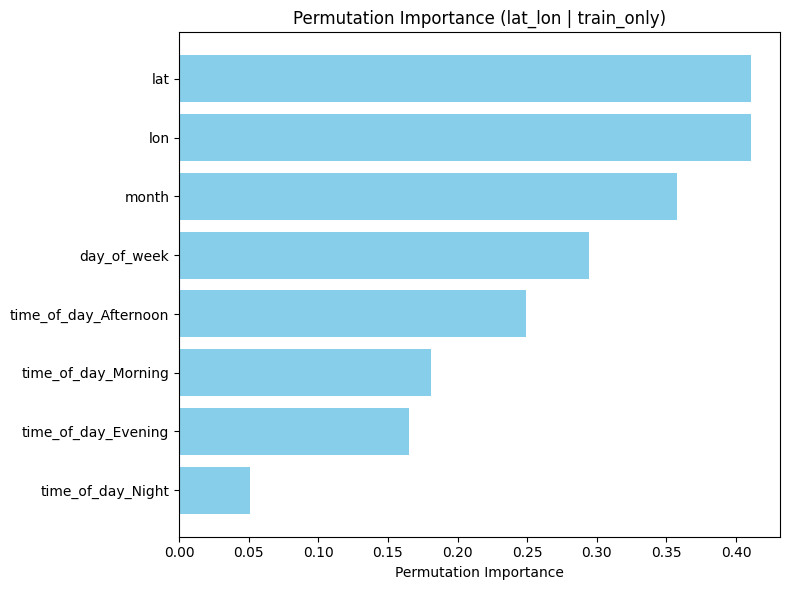

In [53]:
model_latlon_train, gs_latlon_train = analyze_features(
    df, 
    mode="lat_lon", 
    approach="train_only"
)

F1-score:
borough: 0.802
lat_lon: 0.820 ✅ (Better at balancing precision & recall)
AUC-score:
borough: 0.771
lat_lon: 0.873 ✅ (Better at ranking predictions correctly)
Accuracy:
borough: 0.726
lat_lon: 0.838 ✅ (Higher percentage of correct classifications)